In [ ]:
# %%capture
# !pip install voxelmorph
# !pip install tensorflow-addons

In [ ]:
# drive_dir = '/content/drive/MyDrive/Colab Notebooks/'
# workspace = drive_dir + 'DSA-DL/CycleMorph/'
# train_dir = drive_dir + 'PixShift/PixShift_main/datasets/train'
# test_dir = drive_dir + 'PixShift/PixShift_main/datasets/test'

In [1]:
workspace = '/data/ChaochaoData/DSA-DL/HyperMorph/MinMax/'
util_dir = '/data/ChaochaoData/DSA-DL/Utilities/'
train_dir = '/data/ChaochaoData/PixShift/DataSets/PaperData/CombinedTrain'
test_dir = '/data/ChaochaoData/PixShift/DataSets/PaperData/CombinedTest'
cm_train_dir = '/data/ChaochaoData/ClearMatch/nifti_predictions/train_dataset'
cm_test_dir = '/data/ChaochaoData/ClearMatch/nifti_predictions/test_dataset'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import neurite as ne
import voxelmorph as vxm
import tensorflow as tf
# import tensorflow_addons as tfa
import os, sys
import nibabel as nib
import cv2
# from scipy import ndimage
# from IPython import display  # Would conflict with Python's display
import IPython
import logging
import warnings

warnings.filterwarnings('ignore')
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.experimental.output_all_intermediates(True)
tf.compat.v1.disable_eager_execution()
# tf.compat.v1.enable_eager_execution()

2023-09-13 22:56:44.152694: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
import ipywidgets
import bokeh
import bokeh.io
import bokeh.plotting
bokeh.io.output_notebook()

Loading BokehJS ...

In [4]:
sys.path.insert(0, workspace)
from utils import *

Loading BokehJS ...

# Data

In [ ]:
# folders_train = [os.path.join(train_dir, f) for f in sorted(os.listdir(train_dir))
#                  if not os.path.isfile(os.path.join(train_dir, f))]

# folders_test = [os.path.join(test_dir, f) for f in sorted(os.listdir(test_dir))
#                  if not os.path.isfile(os.path.join(test_dir, f))]

# print(len(folders_train), len(folders_test))

In [5]:
folders_train_old = [os.path.join(train_dir, f) for f in sorted(os.listdir(train_dir))
                     if not os.path.isfile(os.path.join(train_dir, f))]
folders_test_old = [os.path.join(test_dir, f) for f in sorted(os.listdir(test_dir))
                    if not os.path.isfile(os.path.join(test_dir, f))]
print(len(folders_train_old), len(folders_test_old))

folders_train_cm = [os.path.join(cm_train_dir, f) for f in sorted(os.listdir(cm_train_dir))
                    if not os.path.isfile(os.path.join(cm_train_dir, f))]
folders_test_cm = [os.path.join(cm_test_dir, f) for f in sorted(os.listdir(cm_test_dir))
                   if not os.path.isfile(os.path.join(cm_test_dir, f))]
print(len(folders_train_cm), len(folders_test_cm))

folders_train = folders_train_old + folders_train_cm
folders_test = folders_test_old + folders_test_cm
print(len(folders_train), len(folders_test))

4946 100
100 94
5046 194


# Model

In [6]:
image_shape = (512, 512)

hp_input = tf.keras.Input(shape=[1])
x = tf.keras.layers.Dense(32, activation='relu')(hp_input)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
hypernetwork = tf.keras.Model(hp_input, x, name='hypernetwork')
# hypernetwork.summary()

model = vxm.networks.VxmDense(image_shape, int_steps=0, bidir=True, hyp_model=hypernetwork)
# model.summary()

In [7]:
model_path = workspace + 'dsa_hyper_cycle.h5'
if os.path.exists(model_path):
  model.load_weights(model_path)
  print("found and loaded model")

In [8]:
def forward_mse(yt, yp, img_sigma=0.3):
  '''
  yt: fixed contrast (with vessel)
  yp: moved background (no vessel)
  '''
  image_no_vessel = tf.math.maximum(yp, yt)
  image_with_vessel = tf.math.minimum(yp, yt)
  loss1 = vxm.losses.MSE(img_sigma).loss(image_no_vessel, yp)
  loss2 = vxm.losses.MSE(img_sigma).loss(image_with_vessel, yt)
  return (loss1 + loss2) / 2

In [9]:
def backward_mse(yt, yp, img_sigma=0.3):
  '''
  yt: fixed background (no vessel)
  yp: moved contrast (with vessel)
  '''
  image_no_vessel = tf.math.maximum(yp, yt)
  image_with_vessel = tf.math.minimum(yp, yt)
  loss1 = vxm.losses.MSE(img_sigma).loss(image_no_vessel, yt)
  loss2 = vxm.losses.MSE(img_sigma).loss(image_with_vessel, yp)
  return (loss1 + loss2) / 2

In [10]:
lambda_weight = hp_input
forward_img_loss = lambda yt, yp: forward_mse(yt, yp) * 0.5 * (1-lambda_weight)
backward_img_loss = lambda yt, yp: backward_mse(yt, yp) * 0.5 * (1-lambda_weight)
gradient_loss = lambda yt, yp: vxm.losses.Grad('l2').loss(yt, yp) * lambda_weight
losses = [forward_img_loss, backward_img_loss, gradient_loss]

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4), loss=losses)

# Visual Examination

In [11]:
i_seq = np.random.randint(len(folders_train))

In [12]:
xrays = load_xray_seq(folders=folders_train, i_seq=i_seq)
print(f'check xray seq range: [{xrays.min()}, {xrays.max()}]')

check xray seq range: [0.0, 1.0]


In [13]:
# inputs, outputs = vxm_seq_generator(folders=folders_train, i_seq=i_seq, nimgs=1, bidir=True)
inputs, outputs = hpm_seq_generator(folders=folders_train, i_seq=i_seq, nimgs=1, nhps=1, bidir=True)
print(np.array_equal(inputs[1], outputs[0]))
print(np.array_equal(inputs[0], outputs[1]))
preds = model.predict(inputs, verbose=0)

True
True


2023-09-13 22:58:44.444144: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-13 22:58:45.256065: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:222] Using CUDA malloc Async allocator for GPU: 0
2023-09-13 22:58:45.256277: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 39200 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:d5:00.0, compute capability: 8.6
2023-09-13 22:58:45.347994: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-09-13 22:58:49.304075: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the ma

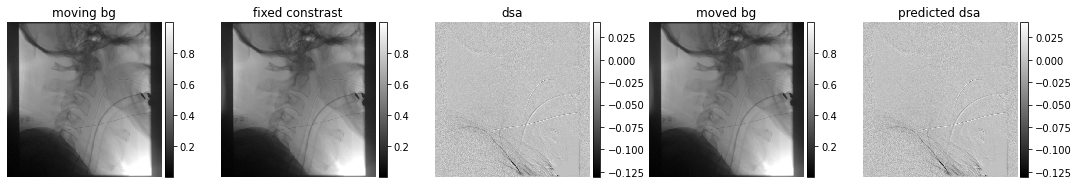

In [14]:
## Forward checking
moving_bg = inputs[0]
fixed_contrast = inputs[1]
dsa = fixed_contrast - moving_bg

moved_bg = preds[0]
dsa_pred = fixed_contrast - moved_bg

images = [moving_bg.squeeze(), fixed_contrast.squeeze(), dsa.squeeze(), moved_bg.squeeze(), dsa_pred.squeeze()]
titles = ['moving bg', 'fixed constrast', 'dsa', 'moved bg', 'predicted dsa']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True, width=len(images)*3);

# img_max = tf.math.maximum(moved_bg, fixed_contrast)
# img_min = tf.math.minimum(moved_bg, fixed_contrast)
# plt.figure()
# plt.subplot(1,2,1)
# plt.imshow(np.squeeze(img_max), cmap='gray')
# plt.subplot(1,2,2)
# plt.imshow(np.squeeze(img_min), cmap='gray')
# plt.show()

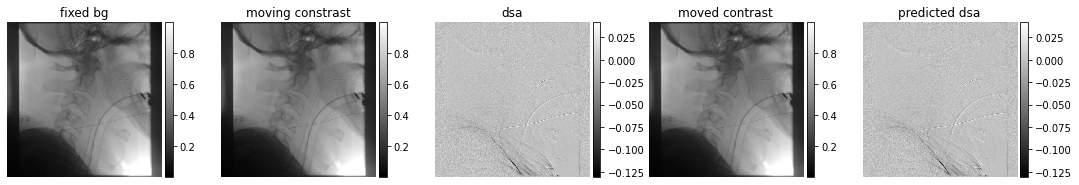

In [15]:
## Backward checking
fixed_bg = inputs[0]
moving_contrast = inputs[1]
dsa = moving_contrast - fixed_bg

moved_contrast = preds[1]
dsa_pred = moved_contrast - fixed_bg

images = [fixed_bg.squeeze(), moving_contrast.squeeze(), dsa.squeeze(), moved_contrast.squeeze(), dsa_pred.squeeze()]
titles = ['fixed bg', 'moving constrast', 'dsa', 'moved contrast', 'predicted dsa']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True, width=len(images)*3);

# img_max = tf.math.maximum(moved_contrast, fixed_bg)
# img_min = tf.math.minimum(moved_contrast, fixed_bg)
# plt.figure()
# plt.subplot(1,2,1)
# plt.imshow(np.squeeze(img_max), cmap='gray')
# plt.subplot(1,2,2)
# plt.imshow(np.squeeze(img_min), cmap='gray')
# plt.show()

# Training

## Single Training

In [16]:
i_seq = np.random.randint(len(folders_train))

In [17]:
# inputs, outputs = vxm_seq_generator(folders_train, i_seq, bidir=True)
inputs, outputs = hpm_seq_generator(folders=folders_train, i_seq=i_seq, nimgs=None, nhps=1, bidir=True)
print(inputs[0].shape, inputs[1].shape, inputs[2].shape)
print(outputs[0].shape, outputs[1].shape, outputs[2].shape)

(33, 512, 512, 1) (33, 512, 512, 1) (33, 1)
(33, 512, 512, 1) (33, 512, 512, 1) (33, 512, 512, 2)


In [18]:
history = model.fit(inputs, outputs, epochs=20, batch_size=1)

Train on 33 samples


2023-09-13 22:59:25.655813: W tensorflow/c/c_api.cc:349] Operation '{name:'vxm_dense_unet_enc_conv_0_0/map/while' id:213 op device:{requested: '', assigned: ''} def:{{{node vxm_dense_unet_enc_conv_0_0/map/while}} = StatelessWhile[T=[DT_INT32, DT_INT32, DT_INT32, DT_VARIANT, DT_INT32, 2612085686982589327, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT], _lower_using_switch_merge=true, _num_original_outputs=30, _read_only_resource_inputs=[], _stateful_parallelism=false, body=vxm_dense_unet_enc_conv_0_0_map_while_body_156[], cond=vxm_dense_unet_enc_conv_0_0_map_while_cond_155[], output_shapes=[[], [], [], [], [], 1123981685360528131, [], [], [], [], []], parallel_iterations=10](vxm_dense_unet_enc_conv_0_0/map/while/loop_counter, vxm_dense_unet_enc_conv_0_0/map/strided_slice, vxm_dense_unet_enc_conv_0_0/map/Const, vxm_dense_unet_enc_conv_0_0/map/TensorArrayV2_3, vxm_dense_unet_enc_conv_0_0/map/strided_slice, vxm_dense_unet_enc_conv_0_0/map/TensorArrayUnstack/TensorListFromTenso

Epoch 1/20
33/33 [==============================] - 8s 98ms/sample - loss: 0.0042 - vxm_dense_transformer_loss: 0.0021 - vxm_dense_neg_transformer_loss: 0.0021 - vxm_dense_flow_loss: 1.0679e-07
Epoch 2/20
33/33 [==============================] - 3s 77ms/sample - loss: 0.0041 - vxm_dense_transformer_loss: 0.0021 - vxm_dense_neg_transformer_loss: 0.0021 - vxm_dense_flow_loss: 1.5090e-06
Epoch 3/20
33/33 [==============================] - 3s 79ms/sample - loss: 0.0040 - vxm_dense_transformer_loss: 0.0020 - vxm_dense_neg_transformer_loss: 0.0020 - vxm_dense_flow_loss: 6.0437e-05
Epoch 4/20
33/33 [==============================] - 3s 82ms/sample - loss: 0.0038 - vxm_dense_transformer_loss: 0.0019 - vxm_dense_neg_transformer_loss: 0.0019 - vxm_dense_flow_loss: 5.9553e-05
Epoch 5/20
33/33 [==============================] - 3s 82ms/sample - loss: 0.0038 - vxm_dense_transformer_loss: 0.0019 - vxm_dense_neg_transformer_loss: 0.0019 - vxm_dense_flow_loss: 9.8914e-05
Epoch 6/20
33/33 [============

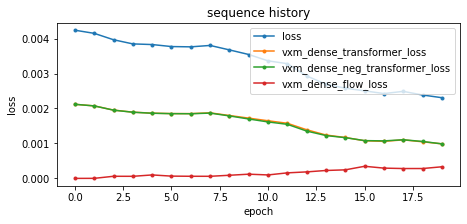

In [19]:
plot_history(history)

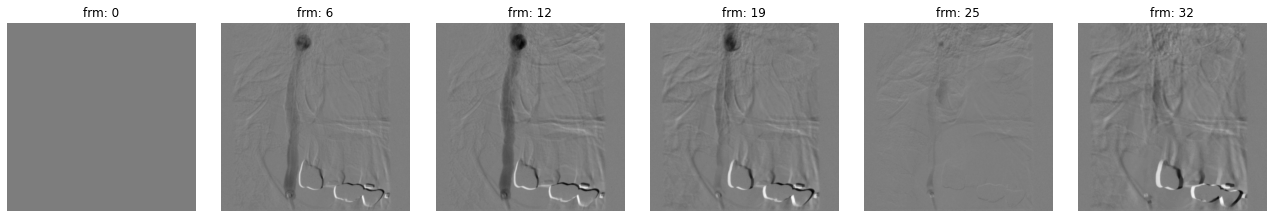

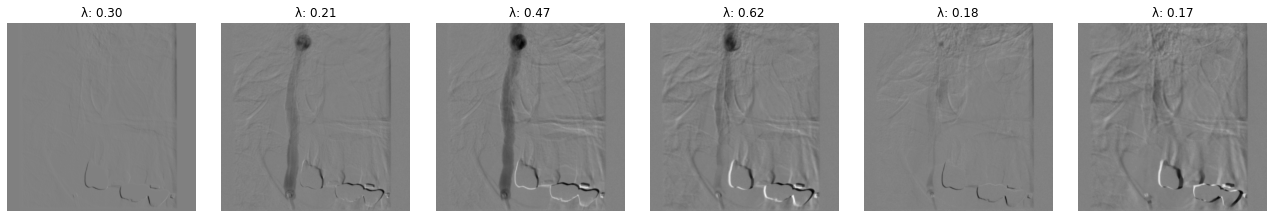

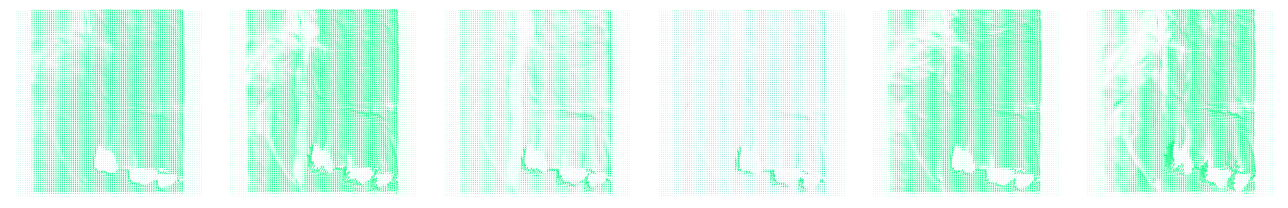

In [20]:
plot_dsa_predictions(model=model, folders=folders_train, i_seq=i_seq, nhps=1)

In [21]:
model.save_weights(model_path)

## Epoch Training

Epoch 2, complete 188 out of 5046 


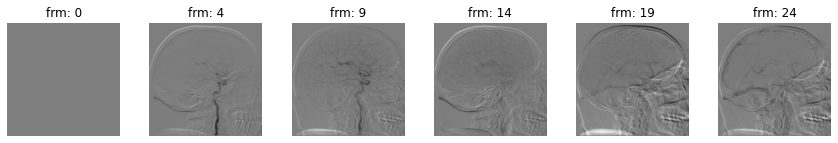

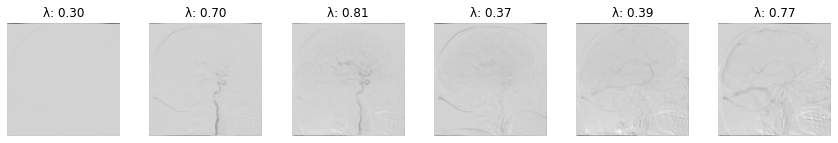

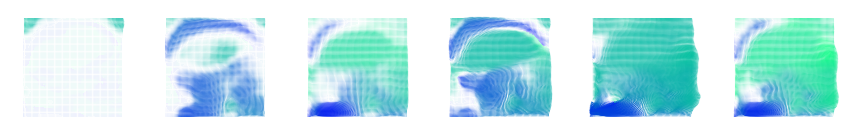

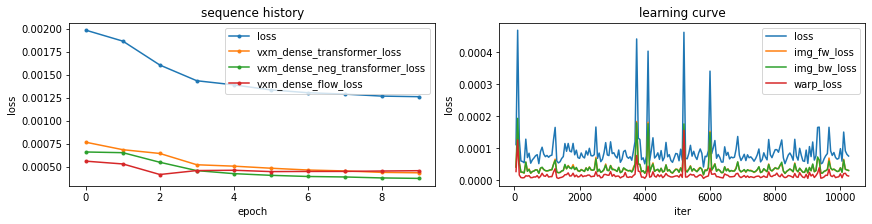

In [ ]:
N_epochs = 5
N_seqs = len(folders_train)
iters_save = 100
iters_lc = 50
iters_plot = 5

global_history = {}
global_history['iter'] = []
global_history['loss'] = []
global_history['img_fw_loss'] = []
global_history['img_bw_loss'] = []
global_history['warp_loss'] = []

iters_count = 0

l = []
l_fw_img = []
l_bw_img = []
l_warp = []

for epoch in range(N_epochs):
  indices_seq = np.random.permutation(N_seqs)
  for i, i_seq in enumerate(indices_seq):
    iters_count += 1

    # inputs, outputs = vxm_seq_generator(folders_train, i_seq=i_seq, nimgs=20, bidir=True)
    inputs, outputs = hpm_seq_generator(folders_train, i_seq=i_seq, nimgs=20, nhps=1, bidir=True)
    seq_history = model.fit(inputs, outputs, epochs=10, batch_size=1, verbose=0)

    l.append(seq_history.history['loss'][-1])
    l_fw_img.append(seq_history.history['vxm_dense_transformer_loss'][-1])
    l_bw_img.append(seq_history.history['vxm_dense_neg_transformer_loss'][-1])
    l_warp.append(seq_history.history['vxm_dense_flow_loss'][-1])

    if iters_count % iters_save == 0:
      model.save_weights(model_path)

    if iters_count % iters_lc == 0:
      global_history['iter'].append(iters_count)
      global_history['loss'].append(np.mean(l))
      global_history['img_fw_loss'].append(np.mean(l_fw_img))
      global_history['img_bw_loss'].append(np.mean(l_bw_img))
      global_history['warp_loss'].append(np.mean(l_warp))
      l = []
      l_fw_img = []
      l_bw_img = []
      l_warp = []

    if iters_count % iters_plot == 0:
      IPython.display.clear_output(wait=True)
      print(f'Epoch {epoch}, complete {i+1} out of {N_seqs} ')
      plot_dsa_predictions(model=model, folders=folders_train, i_seq=i_seq, nhps=1, sub_width=2)
      plot_history(seq_history, global_history, figsize=(12, 3))

model.save_weights(model_path)

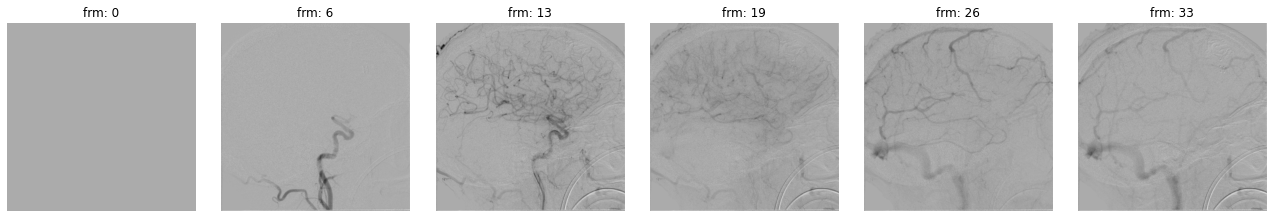

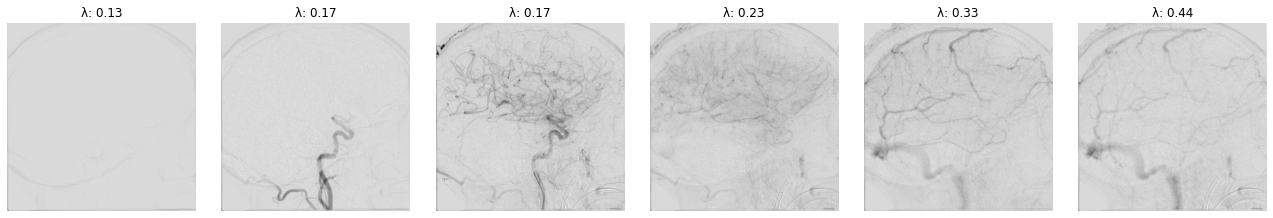

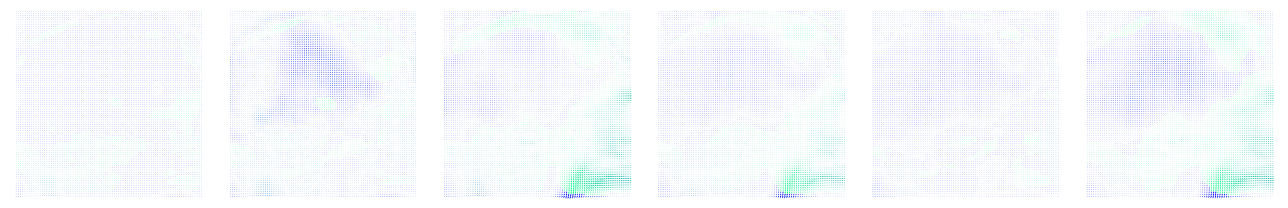

In [23]:
i_seq = np.random.randint(len(folders_train))
plot_dsa_predictions(model=model, folders=folders_train, i_seq=i_seq, nhps=1)

In [24]:
xrays = load_xray_seq(folders=folders_train, i_seq=i_seq)
run_interactive_search_1p(model, xrays, hp0=0.5)

Output()